# **Agrupamento de clientes de banco**

Por **Gustavo Andrade Tavares**

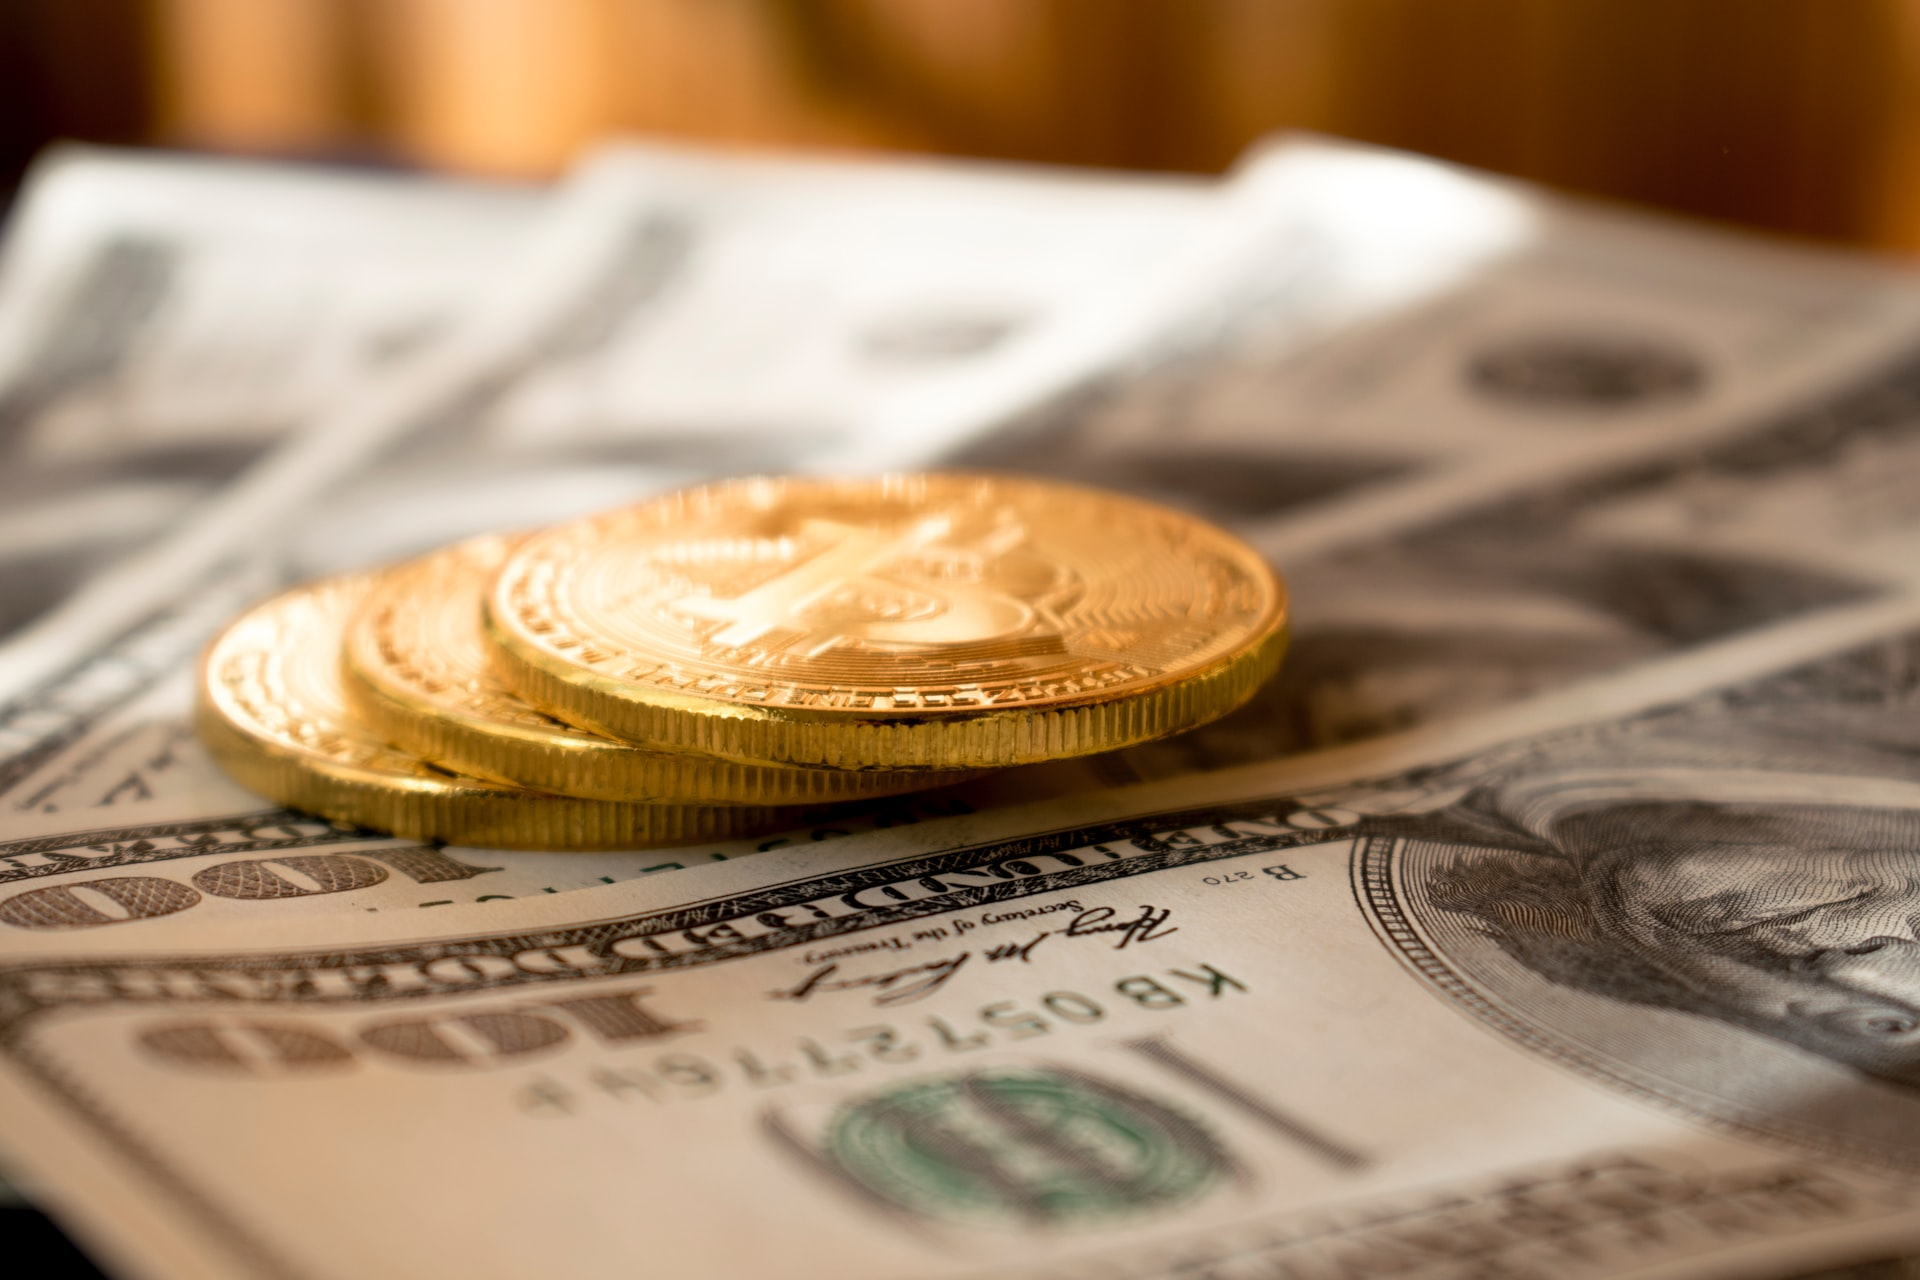

Foto de <a href="https://unsplash.com/@wildbook?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Dmitry Demidko</a> na <a href="https://unsplash.com/pt-br/fotografias/eBWzFKahEaU?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## **1) Introdução**

O conjunto de dados a seguir contém informações de clientes de um determinado banco. Assim, temos as seguintes variáveis:

*   **Customer ID** 
*   **Age** 
*   **Education** 
*   **Years Employed** 
*   **Income** 
*   **Card Debt** 
*   **Other Debt** 
*   **Defaulted** 
*   **Address** 
*   **DebtIncomeRatio** 


Sendo assim, o objetivo deste projeto é fazer o agrupamento de clientes de banco utilizando-se diferentes métodos de **Clustering**.

## **2) Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from scipy.spatial.distance import cdist
from sklearn.metrics.cluster import adjusted_rand_score, mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

## **3) Abertura e Preparação dos Dados**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/gustavo-andrade-tavares/Datasets/main/Cust_Segmentation.csv")
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


Nota-se que há dados faltantes no conjunto de dados, mais especificamente, na variável `Defaulted`, na qual indica se o cliente é inadimplente ou não.

Sendo assim, como é uma variável binária, pois assume valores 0 ou 1, é possível utilizar um método de classificação para poder preencher esses dados faltantes.

Isto é, treina-se um método de classificação com os dados que estão completos e, assim, utiliza-se as observações que têm dados da variável `Defaulted` ausentes para serem classificadas.

Para isso, elimina-se a variável `Address`, pois não é importante, e divide-se o conjunto de dados em treinamento e teste:

In [ ]:
df = df.drop(df.columns[[8]], axis = 1)
train = df.copy()
test = df.copy()

O conjunto de treinamento é formado pelos dados que não têm `NaN`, assim, tem-se:

In [ ]:
train = train.dropna()
train.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      700 non-null    int64  
 1   Age              700 non-null    int64  
 2   Edu              700 non-null    int64  
 3   Years Employed   700 non-null    int64  
 4   Income           700 non-null    int64  
 5   Card Debt        700 non-null    float64
 6   Other Debt       700 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 54.7 KB


Para obter o conjunto com os dados que estão ausentes, é necessário identificar os índices que contêm `NaN`, e assim, para facilitar a manipulação, substitui-se o `NaN` por um número aleatório:

In [ ]:
id = test.Defaulted.to_numpy()
indices = []
for i in range(len(id)):
  if(id[i] != 0 and id[i] != 1):
    indices.append(i)
  else:
    continue

test.loc[indices, 'Defaulted'] = 999
test.head(20)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2
5,6,40,1,23,81,0.998,7.831,999.0,10.9
6,7,38,2,4,56,0.442,0.454,0.0,1.6
7,8,42,3,0,64,0.279,3.945,0.0,6.6
8,9,26,1,5,18,0.575,2.215,999.0,15.5
9,10,47,3,23,115,0.653,3.947,0.0,4.0


Logo, filtra-se o conjunto de dados que contêm a variável `Defaulted = 999` e, assim, obtém-se o conjunto de dados para poder fazer a classificação dos dados:

In [ ]:
test = test[test['Defaulted'] == 999][['Customer Id', 'Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt', 'Defaulted', 'DebtIncomeRatio']]
test.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
5,6,40,1,23,81,0.998,7.831,999.0,10.9
8,9,26,1,5,18,0.575,2.215,999.0,15.5
11,12,34,2,9,40,0.374,0.266,999.0,1.6
13,14,46,1,6,30,1.415,3.865,999.0,17.6
15,16,24,1,1,16,0.185,1.287,999.0,9.2


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 5 to 845
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      150 non-null    int64  
 1   Age              150 non-null    int64  
 2   Edu              150 non-null    int64  
 3   Years Employed   150 non-null    int64  
 4   Income           150 non-null    int64  
 5   Card Debt        150 non-null    float64
 6   Other Debt       150 non-null    float64
 7   Defaulted        150 non-null    float64
 8   DebtIncomeRatio  150 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 11.7 KB


Para utilizar no modelo de classificação, transforma-se os dados no formato do `Numpy`, para facilitar a manipulação:

In [ ]:
train_data = train.to_numpy()
nrow1,ncol1 = train_data.shape
y_train = train_data[:,7]
X_train = train_data[:,[1,2,3,4,5,6,8]]

In [ ]:
test_data = test.to_numpy()
nrow2,ncol2 = test_data.shape
X_test = test_data[:,[1,2,3,4,5,6,8]]

Padronizando-se os dados, uma vez que, as escalas das variáveis são diferentes, tem-se:

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Verificando-se a proporção de Inadimplentes (`Defaulted = 1`) e Não Inadimplentes (`Defaulted = 0`), tem-se:

In [ ]:
prop_um = sum(y_train)/len(y_train)
prop_zero = (len(y_train) - sum(y_train))/len(y_train)

print("Inadimplente: %.2f" %prop_um)
print("Não Inadimplente: %.2f" %prop_zero)

Inadimplente: 0.26
Não Inadimplente: 0.74


Ou seja, nota-se que os dados estão desbalanceados, uma vez que, há mais observações com `Defaulted = 0`.

Divide-se o conjunto de dados de treinamento, `X_train` e `y_train`, em conjunto de treinamento e validação, `x_train, y_train` e `x_val, y_val`.

In [ ]:
p = 0.7 
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, train_size = p, random_state = 42)

Para utilizar os melhores parâmetros do modelo `K-NN`, utiliza-se StratifiedKFold e GridSearchCV:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'n_neighbors' : [i for i in range(1,50)],
              'weights' : ['uniform','distance'],
              'metric' : ['euclidean','manhattan']}
model = KNeighborsClassifier()
best_model_knn = GridSearchCV(model, parameters, cv = cv, scoring = 'f1')
best_model_knn.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
metric, n_neighbors, weights = list(best_model_knn.best_params_.values())[0],list(best_model_knn.best_params_.values())[1],list(best_model_knn.best_params_.values())[2]
print(f'Hiperparâmetros para o melhor modelo de KNN usando recall como score: \nmetric = {metric} \nn_neighbors = {n_neighbors} \nweights = {weights}') 

Hiperparâmetros para o melhor modelo de KNN usando recall como score: 
metric = manhattan 
n_neighbors = 3 
weights = distance


Como o objetivo é classificar os clientes do banco como Inadimplente ou Não Inadimplente, o interesse é minimizar os casos de **Falsos Negativos**, isto é, classificar o cliente que é Inadimplente como Não Inadimplente, na qual pode trazer prejuísos ao banco.

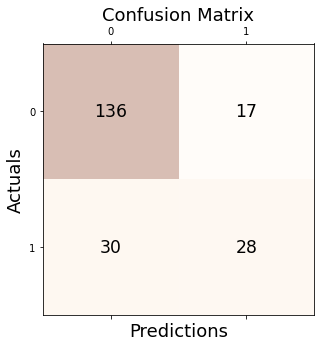

In [ ]:
y_pred_knn = best_model_knn.predict(x_val) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred_knn)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_val, y_pred_knn))
print('Precision: %.3f' % precision_score(y_val, y_pred_knn))
print('Recall: %.3f' % recall_score(y_val, y_pred_knn))
print('F1 Score: %.3f' % f1_score(y_val, y_pred_knn))

Accuracy: 0.777
Precision: 0.622
Recall: 0.483
F1 Score: 0.544


In [ ]:
y_pred = best_model_knn.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
print(y_pred)

[0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0
 1 0]


In [ ]:
for i in range(len(test.index)):
  test.loc[test.index[i], 'Defaulted'] = y_pred[i]

test.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
5,6,40,1,23,81,0.998,7.831,0.0,10.9
8,9,26,1,5,18,0.575,2.215,1.0,15.5
11,12,34,2,9,40,0.374,0.266,0.0,1.6
13,14,46,1,6,30,1.415,3.865,0.0,17.6
15,16,24,1,1,16,0.185,1.287,1.0,9.2


In [ ]:
data = pd.merge(train, test, how = 'outer')
data = data.sort_values(by='Customer Id')
data.reset_index(inplace = True, drop=True)
data.head(20)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2
5,6,40,1,23,81,0.998,7.831,0.0,10.9
6,7,38,2,4,56,0.442,0.454,0.0,1.6
7,8,42,3,0,64,0.279,3.945,0.0,6.6
8,9,26,1,5,18,0.575,2.215,1.0,15.5
9,10,47,3,23,115,0.653,3.947,0.0,4.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        850 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


Retirando-se a variável `Customer ID`, uma vez que não é importante para fazer clustering, tem-se:

In [ ]:
data_seg = data.drop(data.columns[[0]], axis = 1)
data_seg.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


## **4) Visualização e Exploração dos Dados**

Fazendo-se um resumo descritivo dos dados, temos:

In [ ]:
data.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.255294,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.436283,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


Observando-se o comportamento dos dados com base se o cliente é inadimplente ou não:

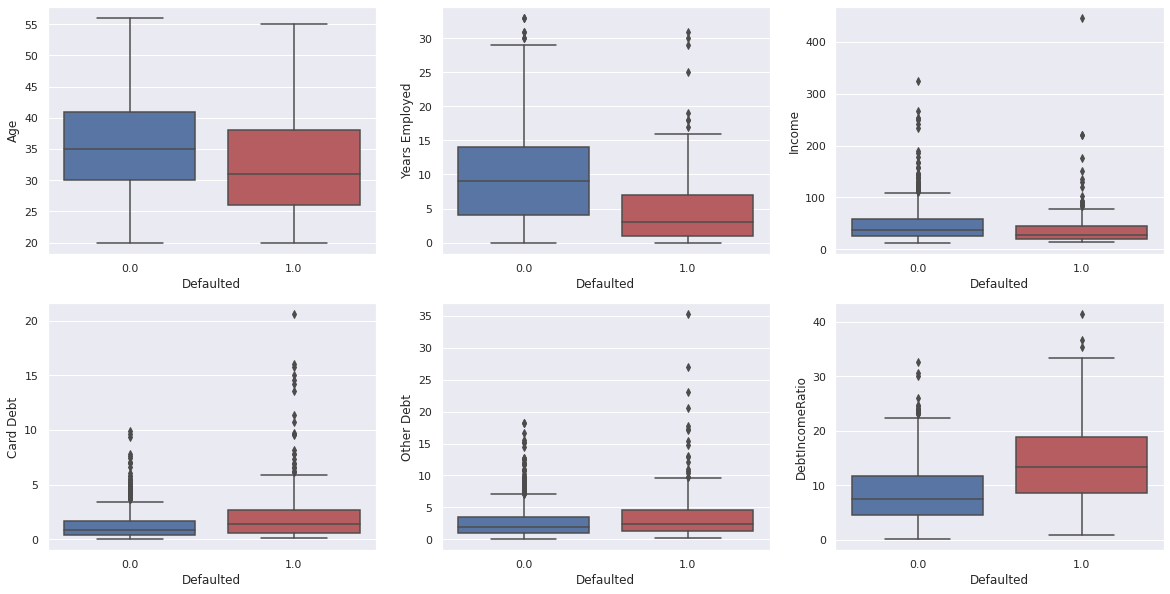

In [ ]:
my_pal = {0: "b", 1:"r"}
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.boxplot(x=data["Defaulted"], y=data["Age"], palette=my_pal, ax=axs[0, 0])
sns.boxplot(x=data["Defaulted"], y=data["Years Employed"], palette=my_pal, ax=axs[0, 1])
sns.boxplot(x=data["Defaulted"], y=data["Income"], palette=my_pal, ax=axs[0, 2])
sns.boxplot(x=data["Defaulted"], y=data["Card Debt"], palette=my_pal, ax=axs[1, 0])
sns.boxplot(x=data["Defaulted"], y=data["Other Debt"], palette=my_pal, ax=axs[1, 1])
sns.boxplot(x=data["Defaulted"], y=data["DebtIncomeRatio"], palette=my_pal, ax=axs[1, 2])

plt.show()

Observando-se o comportamento dos dados de acordo com os níveis de escolaridade:

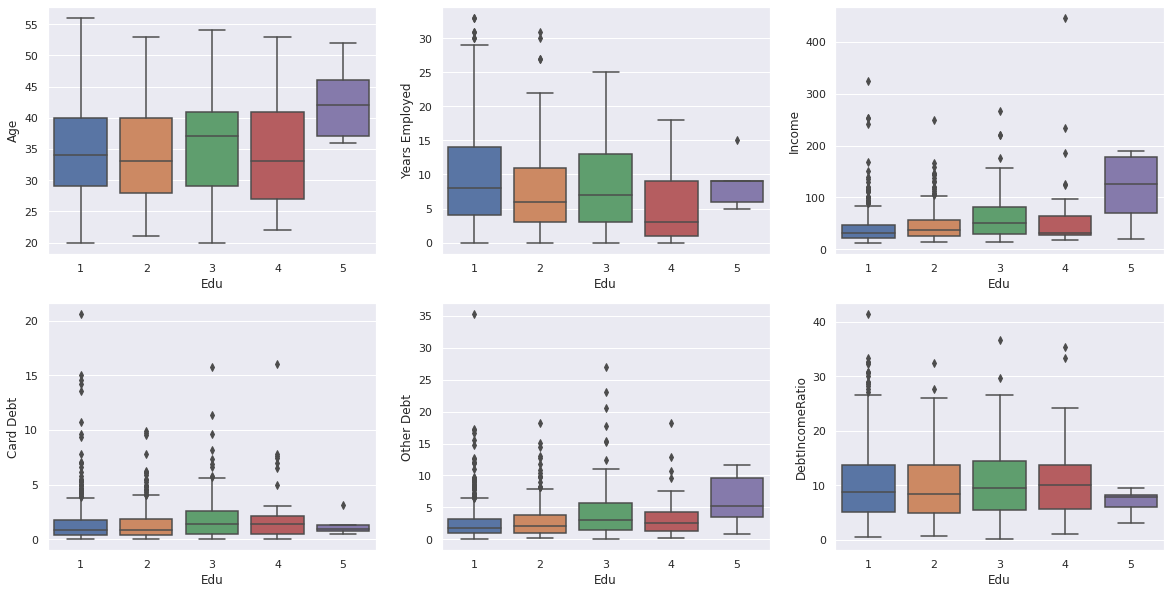

In [ ]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.boxplot(x=data["Edu"], y=data["Age"],  ax=axs[0, 0])
sns.boxplot(x=data["Edu"], y=data["Years Employed"],  ax=axs[0, 1])
sns.boxplot(x=data["Edu"], y=data["Income"],  ax=axs[0, 2])
sns.boxplot(x=data["Edu"], y=data["Card Debt"],  ax=axs[1, 0])
sns.boxplot(x=data["Edu"], y=data["Other Debt"],  ax=axs[1, 1])
sns.boxplot(x=data["Edu"], y=data["DebtIncomeRatio"],  ax=axs[1, 2])

plt.show()

Ou seja, ao observar as variáveis `Age` e `Income`, nota-se que clientes que têm o nível de escolaridade 5, têm as maiores idades e, também, as maiores rendas.

Agora, observando-se as correlações entre as variáveis:

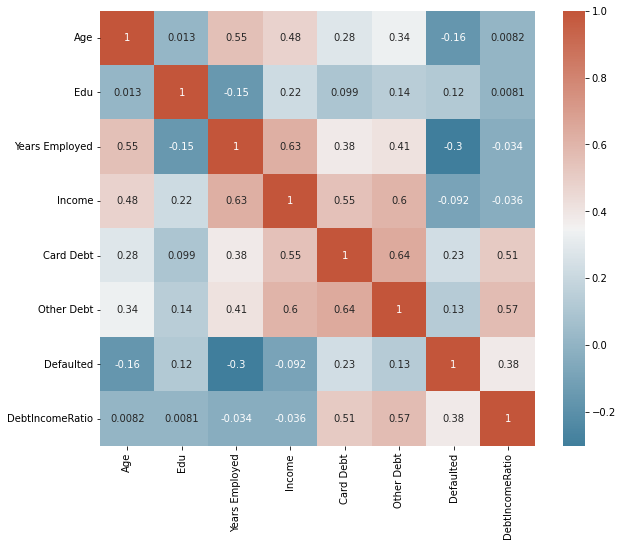

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr = data_seg.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(
    corr, 
    cmap=cmap,
    square=True, 
    annot = True
)
plt.show(True)

Nota-se que as variáveis não estão muito correlacionadas.

Verificando-se o número de clientes de acordo com o nível de escolaridade e se é inadimplente ou não:

In [ ]:
# Tabela de dupla entrada

tabela_dupla = pd.crosstab(index=data_seg['Defaulted'], columns=data_seg['Edu'])

tabela_dupla

Edu,1,2,3,4,5
Defaulted,,,,,
0.0,365,166,67,31,4
1.0,95,69,34,18,1


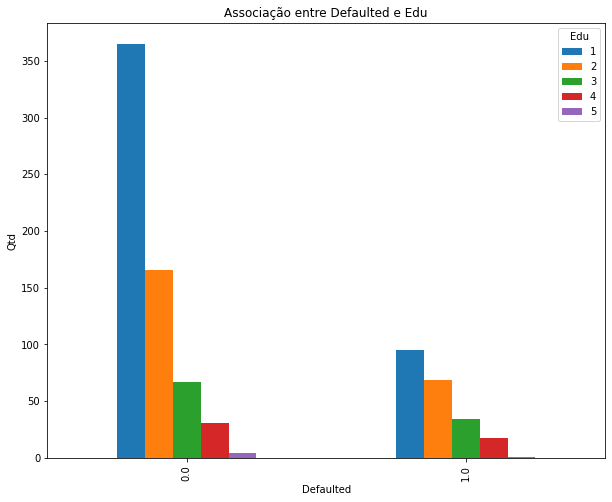

In [ ]:
tabela_dupla.plot.bar(figsize=(10,8),title="Associação entre Defaulted e Edu", ylabel="Qtd")

plt.legend(title='Edu')
plt.show()

Pelo gráfico acima, nota-se que a maioria dos clientes que são inadimplentes, têm o nível de escolaridade 1.

Para verificar a relação entre `Age` e `Income`, considera-se o seguinte scatter plot:

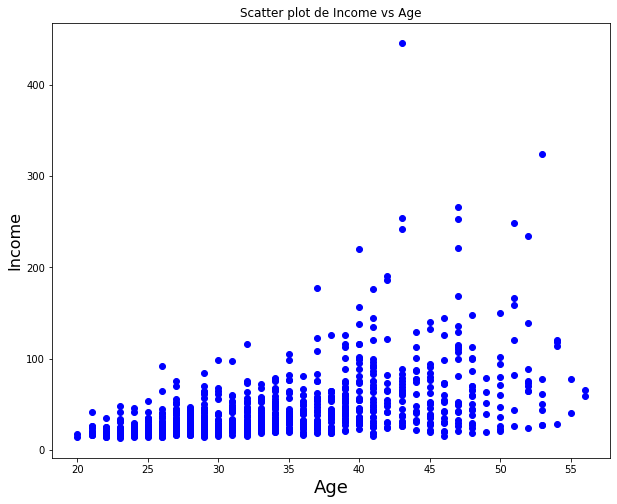

In [ ]:
income = data.Income.to_numpy()
age = data.Age.to_numpy()

plt.figure(figsize=(10,8))
plt.plot(age, income, 'bo')
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)
plt.title("Scatter plot de Income vs Age")
plt.show()

Verificando-se, também, os dados de `Age` e `Income` em relação aos níveis de escolaridade:

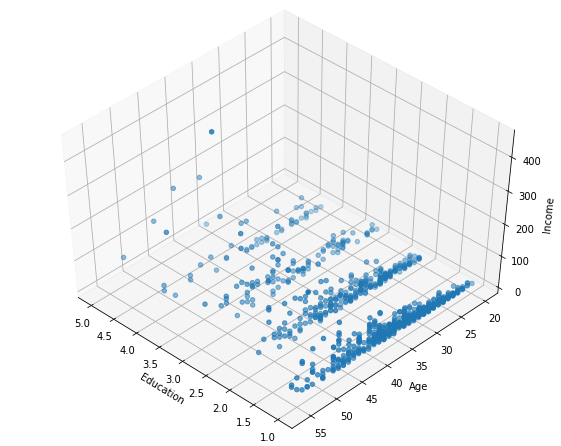

In [ ]:
income = data.Income.to_numpy()
age = data.Age.to_numpy()
edu = data.Edu.to_numpy()

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(edu, age, income)

## **5) Clustering**

Para fazer o agrupamento de clientes do banco que têm características similares, será utilizado os modelos: K-Means, DBSCAN e BIRCH.


### **5.1) K-Means**

O K-Means divide os dados em $k$ grupos ou clusters. Assim, os dados dentro de um cluster são muito similares e os dados de diferentes clusters são muito diferentes.

Assim, o objetivo é formar clusters de uma maneira que amostras similares vão para um cluster e amostras dissimilares vão para outro cluster, utilizando-se uma métrica de dissimilaridade. Ou seja, é feita a minimização da distância intra-cluster e a maximização da distância inter-cluster.

Utilizando-se as variáveis `Age` e `Income`, transforma-se os dados para o formato do `Numpy`, para facilitar a manipulação, e também, fazendo-se a padronização, uma vez que, os dados têm escalas diferentes, tem-se:

In [ ]:
clust_seg = data_seg.values[:,0:]
X = data_seg.values[:,[0,3]]
X = StandardScaler().fit_transform(X)
X

array([[ 0.74291541, -0.71845859],
       [ 1.48949049,  1.38432469],
       [-0.25251804,  0.26803233],
       ...,
       [-1.24795149, -0.74441888],
       [-0.37694723, -0.484816  ],
       [ 2.1116364 ,  0.44975434]])

Para definir o valor de $k$, na qual é o número de clusters, utiliza-se o Elbow Method.  Podemos usar a distância média dos pontos dentro de um cluster até o seu centróide (within-cluster sum of squares, WCSS) para diferentes valores de k.

$$WCSS = \sum_{i=1}^{N_c} \sum_{x \in C_i} d(x, \bar{x}_{C_i})$$

onde $C_i$ é um grupo e $N_i$ é o número de grupos.

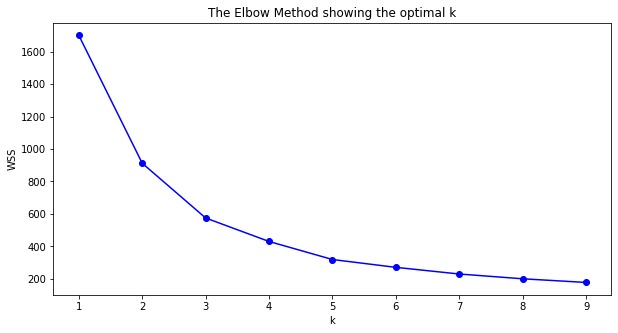

In [ ]:
WCSS= []
K = range(1,10)
# considerando diversos valores de k
for k in K: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # calcula a medida e armazena em uma lista 
    WCSS.append(kmeans.inertia_)

# mostra os resultados
plt.figure(figsize=(10,5))
plt.plot(K, WCSS, '-bo')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Assim, assumindo-se que há três clusters, segue que:

In [ ]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels_km = k_means.labels_
y_km = k_means.fit_predict(X)
print(labels_km)

[1 1 0 0 2 1 1 1 0 2 1 0 0 1 0 0 0 1 1 0 0 1 0 1 2 1 0 1 1 0 1 1 0 1 0 0 0
 0 0 2 0 2 0 2 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0
 0 0 1 0 2 1 0 0 2 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 2 1 1 0 1 1 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1
 0 0 0 1 1 1 1 0 2 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 2 1
 0 1 1 1 1 0 1 1 1 1 0 0 1 2 1 2 1 0 1 1 1 0 2 1 0 0 0 1 1 1 0 1 0 1 1 0 2
 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 2 1 1 0 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 2 2 0 1 0 1 0 1 1 0 1 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 2 0
 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 2 0 0 0 0 1 1 0 0 0 2 0 0 0 1 0 1 2 2 1
 0 0 1 1 0 0 0 0 0 0 1 0 0 1 2 0 1 0 0 1 1 0 1 0 0 0 0 2 1 0 0 0 0 0 0 1 1
 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 2
 1 0 1 1 1 0 1 0 0 0 2 0 0 0 0 1 1 2 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0
 1 1 0 1 0 0 1 0 0 0 1 1 

Para avaliar o quanto um método de agrupamento é preciso, podemos usar diferentes medidas, tais como silhoueta, pureza ou informação mútua.

In [ ]:
print('K-means:')
print('Adjusted rand score:', adjusted_rand_score(y_km, labels_km)) 
print('Mutual information score:', mutual_info_score(y_km, labels_km)) 
print('Silhouette score:', silhouette_score(X, y_km, metric='euclidean'))

K-means:
Adjusted rand score: 1.0
Mutual information score: 0.8642288416699873
Silhouette score: 0.46919759248240167


Incluindo-se os valores de `labels` no dataset:

In [ ]:
data_seg["Clus_km"] = labels_km
data_seg.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_km
0,41,2,6,19,0.124,1.073,0.0,6.3,1
1,47,1,26,100,4.582,8.218,0.0,12.8,1
2,33,2,10,57,6.111,5.802,1.0,20.9,0
3,29,2,4,19,0.681,0.516,0.0,6.3,0
4,47,1,31,253,9.308,8.908,0.0,7.2,2


Obtendo-se os valores médios dos dados de clientes em cada agrupamento:

In [ ]:
data_seg.groupby('Clus_km').mean()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Clus_km,,,,,,,,
0,29.034115,1.692964,5.452026,30.628998,1.075277,2.146614,0.313433,10.270362
1,42.027273,1.642424,11.227273,51.796970,1.776230,3.434306,0.187879,10.184545
2,44.882353,2.313725,19.980392,161.098039,4.898745,9.350471,0.156863,9.180392


Agora, observando-se a distribuição de clientes baseado em `Age` e `Income`:

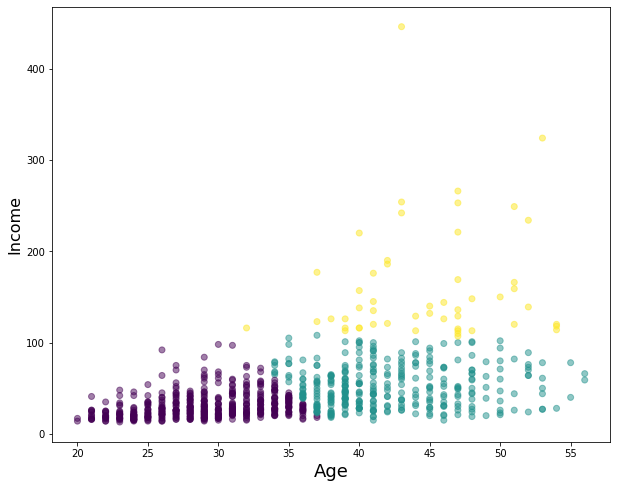

In [ ]:
plt.figure(figsize=(10,8)) 
plt.scatter(clust_seg[:, 0], clust_seg[:, 3], c=labels_km.astype(np.float), alpha=0.5)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)

plt.show()

Além disso, observando-se os dados de acordo com as variáveis: `Age`, `Income` e `Edu`, temos:

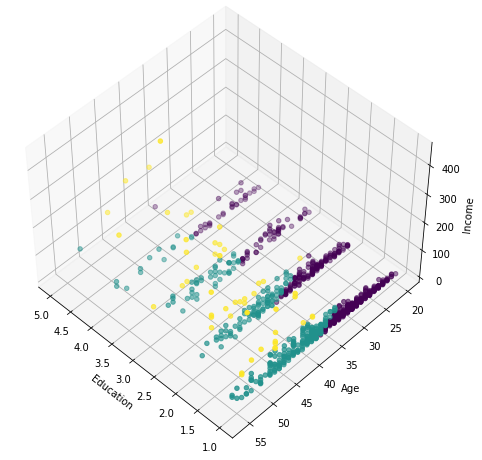

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(clust_seg[:, 1], clust_seg[:, 0], clust_seg[:, 3], c= labels_km.astype(np.float))

Sendo assim, uma possibilidade para identificar os clientes agrupados, que têm características semelhantes:

*  Meia idade e renda alta
*  Adulto e renda média
*  Jovem adulto e renda baixa


### **5.2) DBSCAN**

O DBSCAN, Density-Based Spatial Clustering of Applications with Noise, tem como objetivo encontrar áreas de alta densidade no domínio e expandir essas áreas de forma a encontrar os clusters.

Ao contrário do K-Means, este não exige que seja inserido o número de clusters, uma vez que elabora os grupos com base no número de vizinhos a um ponto e no raio da vizinhança.

Sendo assim, o algoritmo busca criar uma “rede” de pontos vizinhos, de maneira a entender quais pontos estão “juntos” entre si e, portanto, fazem parte do mesmo cluster.

Utilizando-se as variáveis `Age` e `Income`, temos:

In [ ]:
X = data_seg.values[:,[0,3]]
X = StandardScaler().fit_transform(X)

In [ ]:
db = DBSCAN(eps=0.5,min_samples=10).fit(X) 
labels_db = db.labels_
y_db = db.fit_predict(X)

print(y_db)

[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
print('DBSCAN:')
print('Adjusted rand score:', adjusted_rand_score(y_db, labels_db))
print('Mutual information score:', mutual_info_score(y_db, labels_db))
print('Silhouette score:', silhouette_score(X, y_db, metric='euclidean'))

DBSCAN:
Adjusted rand score: 1.0
Mutual information score: 0.1367810240326408
Silhouette score: 0.6554321120928421


Adicionando-se os valores de `labels` no dataset, temos:

In [ ]:
data_seg["Clus_db"] = labels_db
data_seg.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_km,Clus_db
0,41,2,6,19,0.124,1.073,0.0,6.3,1,0
1,47,1,26,100,4.582,8.218,0.0,12.8,1,0
2,33,2,10,57,6.111,5.802,1.0,20.9,0,0
3,29,2,4,19,0.681,0.516,0.0,6.3,0,0
4,47,1,31,253,9.308,8.908,0.0,7.2,2,-1


Obtendo-se os valores médios de cada agrupamento:

In [ ]:
data_seg.groupby('Clus_db').mean()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_km
Clus_db,,,,,,,,,
-1,46.230769,2.346154,20.846154,197.653846,6.030115,11.220462,0.230769,9.400000,2.000000
0,34.675971,1.690534,8.178398,41.911408,1.436303,2.821875,0.256068,10.195995,0.461165


Para visualizar os agrupamentos, temos:

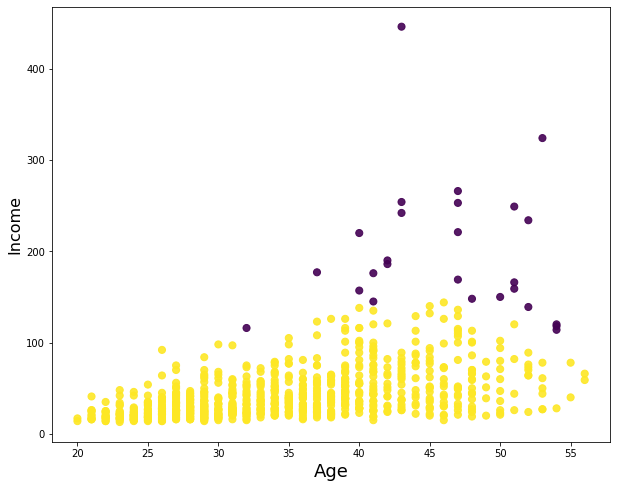

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(clust_seg[:,0], clust_seg[:,3], c=labels_db.astype(np.float), cmap='viridis', s=50, alpha=0.9)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)
plt.show(True)

Ou seja, utilizando-se o DBSCAN, só foi possível definir dois clusters, na qual uma possibilidade para identificar clientes é:



*   Renda baixa ou média
*   Renda alta





### **5.3) BIRCH**

O BIRCH, Balanced Iterative Reducing and Clustering using Hierarchies, é um método hierárquico que pode ser utilizado em grandes datasets, uma vez que, o algoritmo faz um pequeno e compacto sumário do dataset para reter o máximo de informação possível. Assim, é feito o clustering nesse pequeno sumário ao invés de fazer clustering no dataset.

Assim, o BIRCH utiliza os seguintes conceitos: **Clustering Feature (CF) e CF – Tree Clustering Feature (CF)**

O BIRCH sumariza grandes datasets em regiões menores e densas (Clustering Feature) e o conjunto desses CF em forma de árvore é conhecido como CF Tree, que consiste em uma árvore na qual cada folha contém um sub-cluster. 

Transformando-se os dados para o formato do `Numpy`, para facilitar a manipulação, e também, fazendo-se a padronização, uma vez que, os dados têm escalas diferentes, tem-se:

In [ ]:
clust_seg = data_seg.values[:,0:]
X = StandardScaler().fit_transform(clust_seg)
X

array([[ 0.74291541,  0.31212243, -0.37878978, ..., -0.57652509,
         0.8085303 ,  0.17763276],
       [ 1.48949049, -0.76634938,  2.5737211 , ...,  0.39138677,
         0.8085303 ,  0.17763276],
       [-0.25251804,  0.31212243,  0.2117124 , ...,  1.59755385,
        -0.83561026,  0.17763276],
       ...,
       [-1.24795149,  2.46906604, -1.26454304, ...,  3.45892281,
        -0.83561026,  0.17763276],
       [-0.37694723, -0.76634938,  0.50696349, ..., -1.08281745,
        -0.83561026,  0.17763276],
       [ 2.1116364 , -0.76634938,  1.09746566, ..., -0.2340332 ,
         0.8085303 ,  0.17763276]])

In [ ]:
birch = Birch(n_clusters=3) 
labels_b = birch.fit_predict(X) 
y_b = birch.predict(X)

print(y_b)

[0 2 0 0 1 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 2 0 2 0 0 2 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 1
 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 2 0 

Observando-se as métricas:

In [ ]:
print('BIRCH:')
print('Adjusted rand score:', adjusted_rand_score(y_b, labels_b))
print('Mutual information score:', mutual_info_score(y_b, labels_b))
print('Silhouette score:', silhouette_score(X, y_b, metric='euclidean'))

BIRCH:
Adjusted rand score: 1.0
Mutual information score: 0.4268955334052378
Silhouette score: 0.34501661228018693


Adicionando-se os valores de `labels` no dataset:

In [ ]:
data_seg["Clus_b"] = labels_b
data_seg.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_km,Clus_db,Clus_b
0,41,2,6,19,0.124,1.073,0.0,6.3,1,0,0
1,47,1,26,100,4.582,8.218,0.0,12.8,1,0,2
2,33,2,10,57,6.111,5.802,1.0,20.9,0,0,0
3,29,2,4,19,0.681,0.516,0.0,6.3,0,0,0
4,47,1,31,253,9.308,8.908,0.0,7.2,2,-1,1


Observando-se os valores médios dos dados de cada agrupamento:

In [ ]:
data_seg.groupby('Clus_km').mean()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_db,Clus_b
Clus_km,,,,,,,,,,
0,29.034115,1.692964,5.452026,30.628998,1.075277,2.146614,0.313433,10.270362,0.000000,0.008529
1,42.027273,1.642424,11.227273,51.796970,1.776230,3.434306,0.187879,10.184545,0.000000,0.278788
2,44.882353,2.313725,19.980392,161.098039,4.898745,9.350471,0.156863,9.180392,-0.509804,1.490196


Visualizando-se os dados de acordo com `Age` e `Income`:

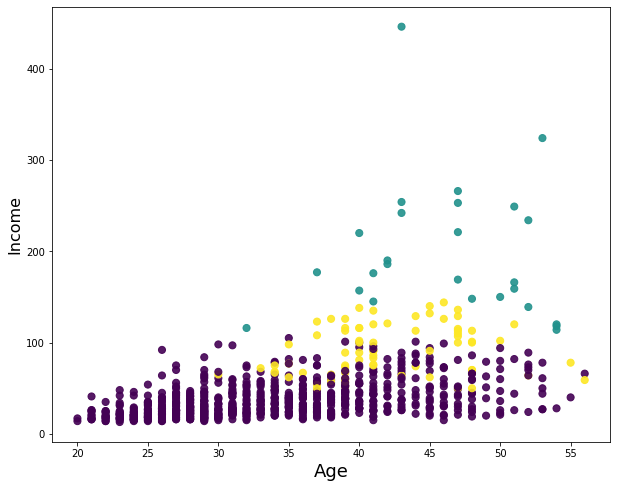

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(clust_seg[:,0], clust_seg[:,3], c=labels_b.astype(np.float), cmap='viridis', s=50, alpha=0.9)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)
plt.show(True)

Agora, visualizando-se os dados de acordo com `Age`, `Income` e `Edu`:

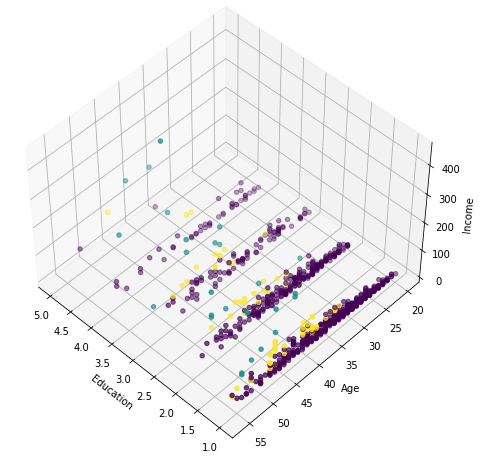

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(clust_seg[:, 1], clust_seg[:, 0], clust_seg[:, 3], c= labels_b.astype(np.float))

Semelhantemente ao K-Means, é possível identificar os clientes por meio das características:


*  Meia idade e renda alta
*  Adulto e renda média
*  Jovem adulto e renda baixa

## **6) Conclusão**

Nesse projeto, o objetivo foi fazer o agrupamento de clientes de um determinado banco, utilizando-se os algoritmos de clustering: K-Means, DBSCAN e BIRCH.

Como havia dados faltantes na variável `defaulted`, foi necessário preencher esses dados utilizando um método de classificação, como o K-NN. 

Ao utilizar os métodos de clustering, foram obtidos resultados diferentes nos três algoritmos estudados. Além disso, foram utilizadas diferentes métricas de similaridade, tais como: Adjusted rand score, Mutual information score e Silhouette score.

Com o K-Means, foram obtidas três regiões ao estudar as relações entre `Age` e `Income`. Assim, é possível segmentar os clientes como: Meia idade e renda alta; Adulto e renda média; Jovem adulto e renda baixa.

Além disso, obteve-se as seguintes métricas:
* **Adjusted rand score:** $1.0$
* **Mutual information score:** $0.8642$
* **Silhouette score:** $0.4692$


Com o DBSCAN, foram obtidas apenas duas regiões ao estudar as relações entre `Age` e `Income`. Assim, agrupa-se os clientes como: Renda baixa ou média; Renda alta.

Assim, obteve-se as seguintes métricas:

*  **Adjusted rand score:** $1.0$
*  **Mutual information score:** $0.1368$
*  **Silhouette score:** $0.6554$

Com o BIRCH, ao dividir os dados em três clusters, os resultados são um pouco diferentes em relação ao K-Means. Assim, agrupa-se os clientes como: Renda baixa; Renda média;  Renda alta.

Logo, as métricas obtidas são:

*  **Adjusted rand score:** $1.0$
*  **Mutual information score:** $0.4269$
*  **Silhouette score:** $0.3450$

Para escolher um modelo de clustering, utiliza-se a métrica Silhouette score como referência, na qual o melhor valor é 1 e o pior valor é -1 e valores próximos a 0 indicam clusters sobrepostos.

Sendo assim, escolhe-se o **DBSCAN** para fazer a segmentação de clientes, utilizando-se os dados de `Age` e `Income`, uma vez que, este modelo tem o maior valor de Silhouette score do que o K-Means e o BIRCH.